In [1]:
import numpy as np
import pandas as pd
from cellpose import models, io, plot
import matplotlib.pyplot as plt
from skimage import measure
from skimage.filters import threshold_otsu
from skimage import morphology




Welcome to CellposeSAM, cellpose v
cellpose version: 	4.0.4 
platform:       	darwin 
python version: 	3.9.22 
torch version:  	2.7.0! The neural network component of
CPSAM is much larger than in previous versions and CPU excution is slow. 
We encourage users to use GPU/MPS if available. 




In [2]:


# # File paths
# mhtt_path = '/Users/noahwijnheijmer/Library/CloudStorage/OneDrive-HvA/afstuderen/20240212_CKR_E10B_mHtt-HAQ97doxy48h_BafA1_HA-STAR580_CCCT1-STAR635P_A11-STAR460L_nucspotlive488_3.lif - C=0.tif'
# cct1_path = '/Users/noahwijnheijmer/Library/CloudStorage/OneDrive-HvA/afstuderen/20240212_CKR_E10B_mHtt-HAQ97doxy48h_BafA1_HA-STAR580_CCCT1-STAR635P_A11-STAR460L_nucspotlive488_3.lif - C=1.tif'

# # Load the TIFF files
# mhtt_data = tifffile.imread(mhtt_path)  # Shape: (Z, Y, X)
# cct1_data = tifffile.imread(cct1_path)  # Shape: (Z, Y, X)

# # Verify the shapes
# print(f"mHTT data shape: {mhtt_data.shape}")
# print(f"CCT1 data shape: {cct1_data.shape}")

# # Create output directories for Z-slices
# mhtt_output_dir = "mhtt_z_slices"
# cct1_output_dir = "cct1_z_slices"
# os.makedirs(mhtt_output_dir, exist_ok=True)
# os.makedirs(cct1_output_dir, exist_ok=True)

# # Save each Z-slice as a separate TIFF file
# for z in range(mhtt_data.shape[0]):
#     mhtt_slice_path = os.path.join(mhtt_output_dir, f"mhtt_slice_{z}.tiff")
#     cct1_slice_path = os.path.join(cct1_output_dir, f"cct1_slice_{z}.tiff")
    
#     # Save mHTT Z-slice
#     tifffile.imwrite(mhtt_slice_path, mhtt_data[z])
    
#     # Save CCT1 Z-slice
#     tifffile.imwrite(cct1_slice_path, cct1_data[z])

# print(f"Saved {mhtt_data.shape[0]} Z-slices for mHTT to '{mhtt_output_dir}'")
# print(f"Saved {cct1_data.shape[0]} Z-slices for CCT1 to '{cct1_output_dir}'")

# # Display all Z-slices in a grid
# num_slices = mhtt_data.shape[0]
# grid_size = int(np.ceil(np.sqrt(num_slices)))

# # Create a figure to display all mHTT Z-slices
# fig1, axes1 = plt.subplots(grid_size, grid_size, figsize=(15, 15))
# fig1.suptitle('mHTT Z-Slices', fontsize=16)

# # Create a figure to display all CCT1 Z-slices
# fig2, axes2 = plt.subplots(grid_size, grid_size, figsize=(15, 15))
# fig2.suptitle('CCT1 Z-Slices', fontsize=16)

# # Normalize the intensity for better visualization
# def normalize(img):
#     return (img - img.min()) / (img.max() - img.min())

# # Plot each Z-slice
# for z in range(num_slices):
#     row, col = z // grid_size, z % grid_size
    
#     # mHTT slice
#     ax1 = axes1[row, col]
#     ax1.imshow(normalize(mhtt_data[z]), cmap='gray')
#     ax1.set_title(f"Slice {z}")
#     ax1.axis('off')
    
#     # CCT1 slice
#     ax2 = axes2[row, col]
#     ax2.imshow(normalize(cct1_data[z]), cmap='gray')
#     ax2.set_title(f"Slice {z}")
#     ax2.axis('off')

# # Turn off remaining empty subplots
# for z in range(num_slices, grid_size**2):
#     row, col = z // grid_size, z % grid_size
#     axes1[row, col].axis('off')
#     axes2[row, col].axis('off')

# plt.tight_layout()
# plt.show()

# # Create maximum intensity projections (MIP)
# mhtt_mip = np.max(mhtt_data, axis=0)
# cct1_mip = np.max(cct1_data, axis=0)

# plt.figure(figsize=(12, 6))
# plt.subplot(1, 2, 1)
# plt.imshow(normalize(mhtt_mip), cmap='gray')
# plt.title("mHTT Maximum Intensity Projection")
# plt.axis('off')

# plt.subplot(1, 2, 2)
# plt.imshow(normalize(cct1_mip), cmap='gray')
# plt.title("CCT1 Maximum Intensity Projection")
# plt.axis('off')

# plt.tight_layout()
# plt.show()

# Cellpose implementation

In [3]:
tif_file= f"/Users/noahwijnheijmer/Library/CloudStorage/OneDrive-HvA/afstuderen/Microscopy Data Huntingtin aggregates/Raw data #1/20240212_CKR_E10B_mHtt-HAQ97doxy48h_BafA1_HA-STAR580_CCCT1-STAR635P_A11-STAR460L_nucspotlive488_3_MAX_Composite.tif"
img = io.imread(tif_file) # (9, 4, 1024, 1024)
print(f'img : {img.shape}')

img : (4, 2048, 2048)


In [4]:
model = models.CellposeModel()
# NUCLEI
nuclei = img[2, :, :]
print(f'Nuclei : {nuclei.shape}')

# CCT1
CCT1 = img[0, :, :]
print(f'CCT1 : {CCT1.shape}')

# mHTT
mHTT = img[1, :, :] 
print(f'mHTT : {mHTT.shape}')

Nuclei : (2048, 2048)
CCT1 : (2048, 2048)
mHTT : (2048, 2048)


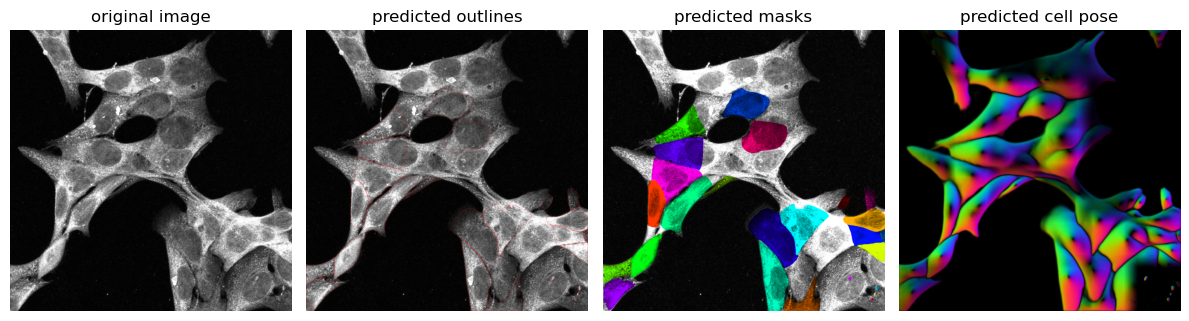

In [5]:
mHTT_masks, mHTT_flows, mHTT_styles = model.eval(
                                                        mHTT,
                                                        batch_size=8, 
                                                        flow_threshold=0.4, 
                                                        cellprob_threshold=0.0, 
                                                        diameter=50,
                                                        normalize={"tile_norm_blocksize": 0}
                                                    )

fig = plt.figure(figsize=(12,5))
plot.show_segmentation(fig, mHTT, mHTT_masks, mHTT_flows[0])
plt.tight_layout()
plt.show()

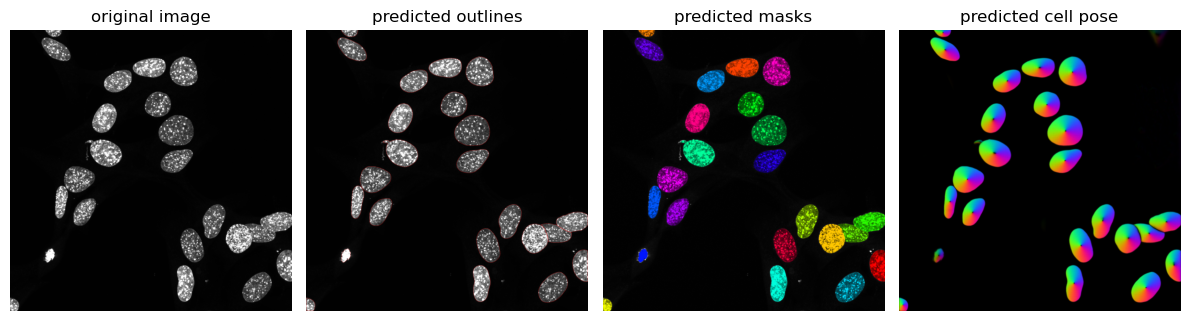

In [6]:


masks_nuclei, flows_nuclei, styles_nuclei = model.eval(
                                                        nuclei,
                                                        batch_size=8, 
                                                        flow_threshold=0.4, 
                                                        cellprob_threshold=0.0, 
                                                        diameter=50,
                                                        normalize={"tile_norm_blocksize": 0}
                                                    )

fig = plt.figure(figsize=(12,5))
plot.show_segmentation(fig, nuclei, masks_nuclei, flows_nuclei[0])
plt.tight_layout()
plt.show()

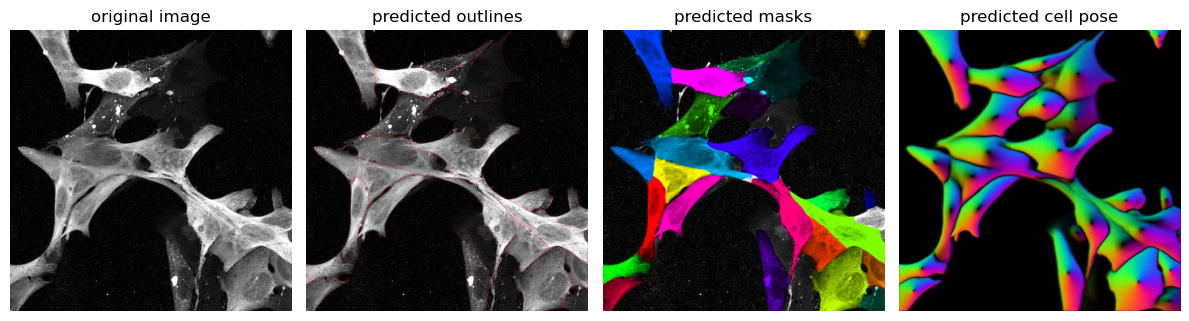

In [7]:
masks_CCT1, flows_CCT1, styles_CCT1 = model.eval(
                                                        CCT1,
                                                        batch_size=8, 
                                                        flow_threshold=0.4, 
                                                        cellprob_threshold=0.0, 
                                                        diameter=100,
                                                        normalize={"tile_norm_blocksize": 0}
                                                    )

fig = plt.figure(figsize=(12,5))
plot.show_segmentation(fig, CCT1, masks_CCT1, flows_CCT1[0])
plt.tight_layout()
plt.show()

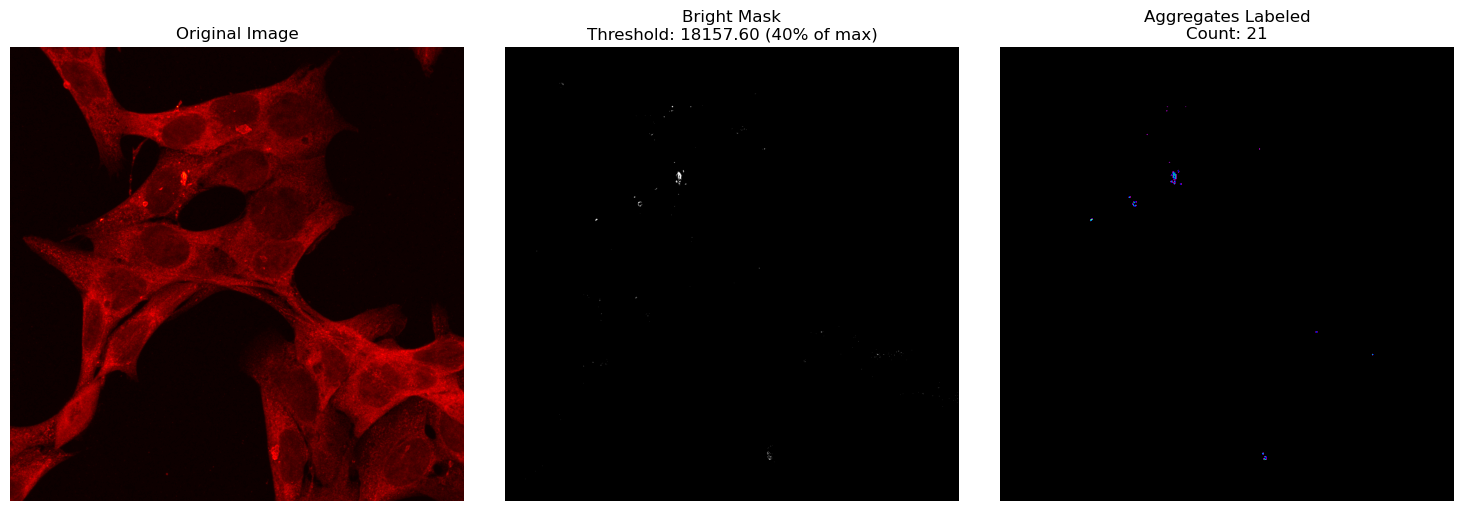

Total aggregations: 21


In [8]:


# Use Otsu's method for automatic thresholding
# This finds optimal threshold by maximizing variance between foreground and background
thresh_otsu = threshold_otsu(mHTT)

# Create binary mask by applying Otsu threshold
bright_spots = mHTT > thresh_otsu
# Use a relative threshold (40% of max intensity) instead of Otsu
# This gives better control over aggregate detection sensitivity
threshold = 0.4 * np.max(mHTT)

# Create binary mask by applying threshold
bright_spots = mHTT > threshold

# Remove small objects (noise) from the binary mask
# min_size=10 removes connected regions smaller than 10 pixels
clean_mask = morphology.remove_small_objects(bright_spots, min_size=10)

# Label connected components (each distinct region gets unique integer ID)
labeled_mask = measure.label(clean_mask)
num_aggregations = labeled_mask.max()  # Count the number of unique regions

# Visualization section - create figure with 3 panels
plt.figure(figsize=(15, 5))

# Panel 1: Display original image using 'hot' colormap to highlight bright aggregates
plt.subplot(1, 3, 1)
plt.imshow(mHTT, cmap='hot')
plt.axis('off')
plt.title('Original Image')

# Panel 2: Show binary mask (threshold result)
plt.subplot(1, 3, 2)
plt.imshow(bright_spots, cmap='gray')
plt.axis('off')
plt.title(f'Bright Mask\nThreshold: {threshold:.2f} (40% of max)')

# Panel 3: Show labeled regions with different colors
# nipy_spectral colormap gives distinct colors to different labeled regions
plt.subplot(1, 3, 3)
plt.imshow(labeled_mask, cmap='nipy_spectral')
plt.axis('off')
plt.title(f'Aggregates Labeled\nCount: {num_aggregations}')

plt.tight_layout()
plt.show()

# Print summary statistics
print(f"Total aggregations: {num_aggregations}")


CCT1 background mean: 7299.31, std: 9707.77
CCT1 thresholds - Otsu: 11891.0, BG+2σ: 26714.8, BG+3σ: 36422.6


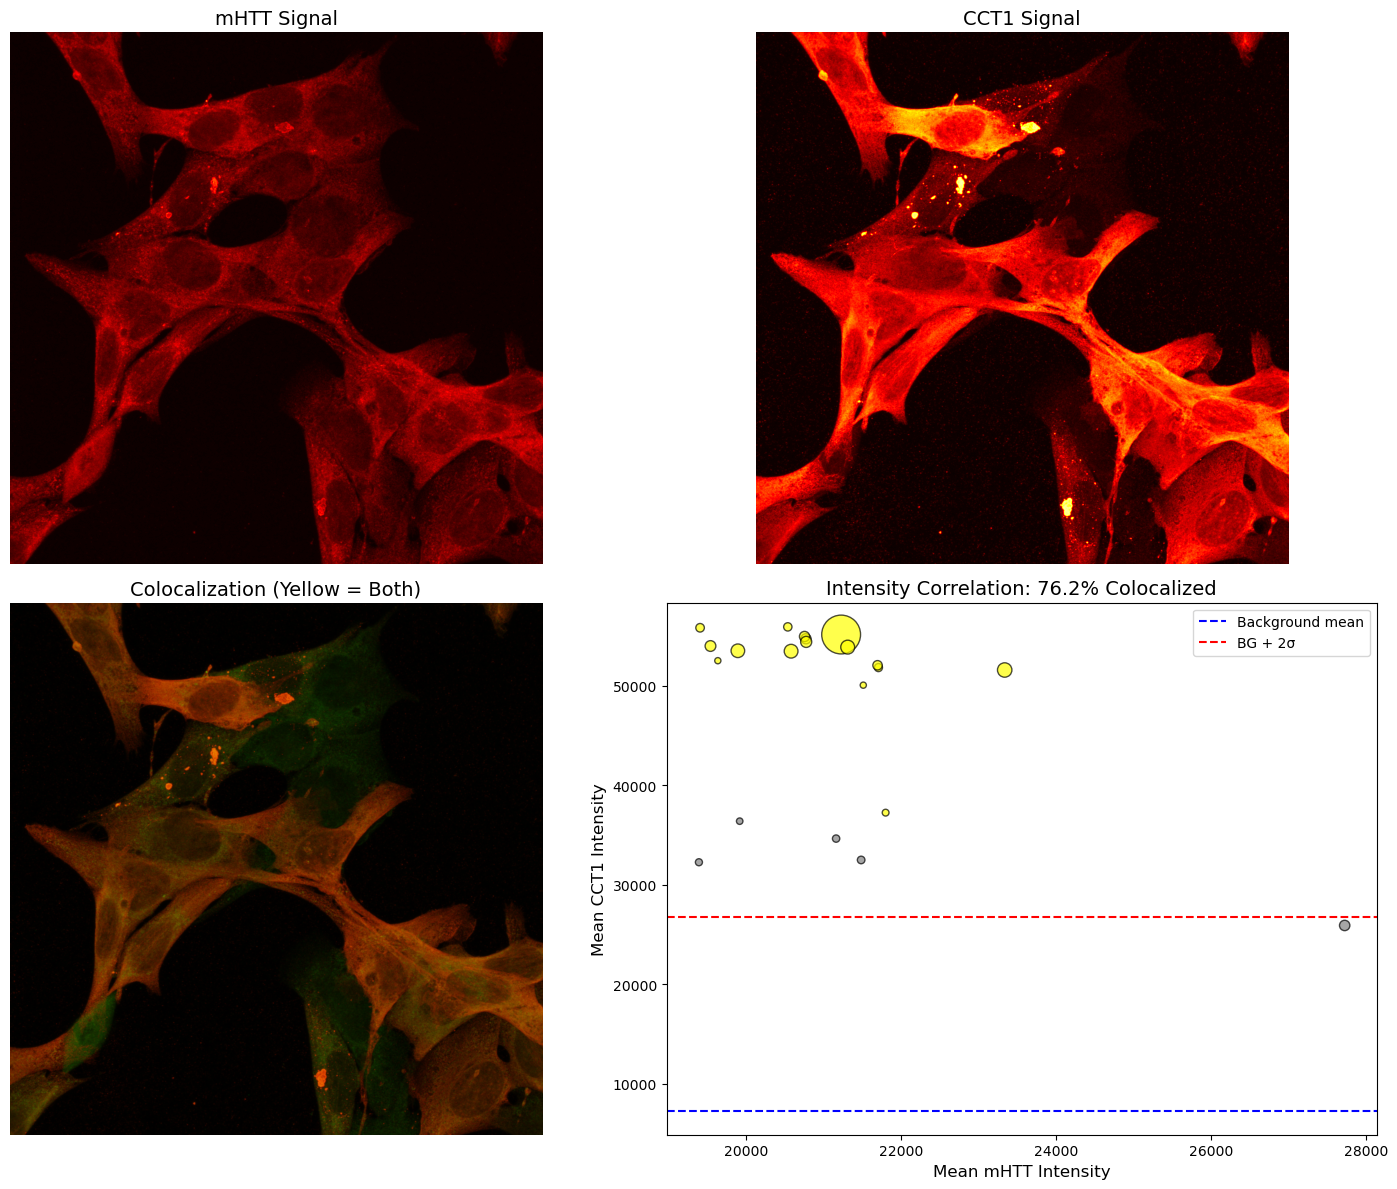

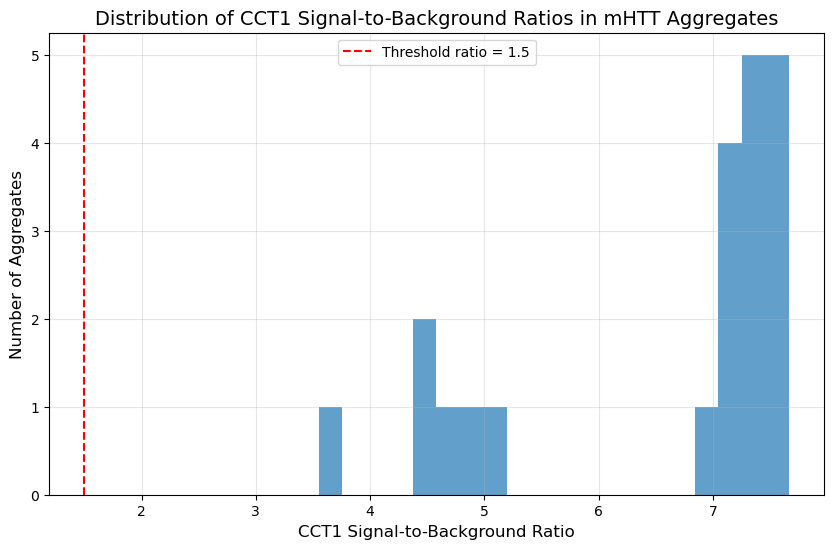

Total mHTT aggregates: 21
Aggregates with CCT1 colocalization (strict criteria): 16 (76.2%)

Top 5 aggregates by CCT1 signal-to-background ratio:
    aggregate_id   area     mean_mHTT     mean_CCT1  signal_to_bg_ratio  \
18            19   18.0  20536.277778  55934.444444            7.662981   
19            20   19.0  19403.526316  55843.947368            7.650583   
7              8  391.0  21224.892583  55165.948849            7.557697   
10            11   27.0  20752.259259  54968.296296            7.530619   
9             10   27.0  20770.407407  54738.851852            7.499185   

     z_score  
18  5.009919  
19  5.000597  
7   4.930756  
10  4.910396  
9   4.886761  


In [9]:


# 1. Get mHTT aggregates from labeled_mask
mhtt_props = measure.regionprops(labeled_mask, intensity_image=mHTT)

# 2. Calculate background CCT1 signal by sampling regions outside aggregates
# Create a mask of non-aggregate regions
background_mask = labeled_mask == 0
# Sample CCT1 values from background regions
background_cct1 = CCT1[background_mask]
background_mean = np.mean(background_cct1)
background_std = np.std(background_cct1)

print(f"CCT1 background mean: {background_mean:.2f}, std: {background_std:.2f}")

# Define multiple threshold methods for comparison
cct1_thresh_otsu = threshold_otsu(CCT1)
cct1_thresh_bg_plus_2std = background_mean + (2 * background_std)  # 2 standard deviations above background
cct1_thresh_bg_plus_3std = background_mean + (3 * background_std)  # 3 standard deviations above background

print(f"CCT1 thresholds - Otsu: {cct1_thresh_otsu:.1f}, BG+2σ: {cct1_thresh_bg_plus_2std:.1f}, BG+3σ: {cct1_thresh_bg_plus_3std:.1f}")

# 3. Analyze each mHTT aggregate for CCT1 colocalization with multiple criteria
colocalization_data = []

for i, region in enumerate(mhtt_props):
    # Get the coordinates of this aggregate
    coords = region.coords  # Array of (row, col) coordinates
    
    # Extract CCT1 intensities at these same coordinates
    cct1_values = np.array([CCT1[y, x] for y, x in coords])
    
    # Calculate statistics
    mean_cct1 = np.mean(cct1_values)
    max_cct1 = np.max(cct1_values)
    
    # Calculate signal-to-background ratio
    signal_to_bg_ratio = mean_cct1 / background_mean if background_mean > 0 else 0
    
    # Z-score relative to background
    z_score = (mean_cct1 - background_mean) / background_std if background_std > 0 else 0
    
    # Determine colocalization by different criteria
    percent_above_otsu = np.mean(cct1_values > cct1_thresh_otsu) * 100
    percent_above_2std = np.mean(cct1_values > cct1_thresh_bg_plus_2std) * 100
    percent_above_3std = np.mean(cct1_values > cct1_thresh_bg_plus_3std) * 100
    
    # Stringent colocalization criteria (multiple must be met)
    has_cct1_strict = (signal_to_bg_ratio > 1.5) and (z_score > 3) and (percent_above_2std > 50)
    
    # Store data for this aggregate
    colocalization_data.append({
        'aggregate_id': i+1,
        'area': region.area,
        'mean_mHTT': region.mean_intensity,
        'mean_CCT1': mean_cct1,
        'max_CCT1': max_cct1,
        'signal_to_bg_ratio': signal_to_bg_ratio,
        'z_score': z_score,
        'percent_above_otsu': percent_above_otsu,
        'percent_above_2std': percent_above_2std,
        'percent_above_3std': percent_above_3std,
        'has_CCT1_colocalization': has_cct1_strict
    })

# 4. Convert to DataFrame for analysis
df_colocalization = pd.DataFrame(colocalization_data)

# 5. Calculate summary statistics
total_aggregates = len(df_colocalization)
colocalized_aggregates = df_colocalization['has_CCT1_colocalization'].sum()
percent_colocalized = (colocalized_aggregates / total_aggregates) * 100 if total_aggregates > 0 else 0

# 6. Visualize the results
fig, axs = plt.subplots(2, 2, figsize=(15, 12))

# Original images
axs[0, 0].imshow(mHTT, cmap='hot')
axs[0, 0].set_title('mHTT Signal', fontsize=14)
axs[0, 0].axis('off')

axs[0, 1].imshow(CCT1, cmap='hot')
axs[0, 1].set_title('CCT1 Signal', fontsize=14)
axs[0, 1].axis('off')

# Create RGB overlay showing colocalization
overlay = np.zeros((mHTT.shape[0], mHTT.shape[1], 3), dtype=float)
# Normalize channels for visualization
mhtt_norm = (mHTT - np.min(mHTT)) / (np.max(mHTT) - np.min(mHTT))
cct1_norm = (CCT1 - np.min(CCT1)) / (np.max(CCT1) - np.min(CCT1))
# Green for mHTT, Red for CCT1
overlay[:,:,1] = mhtt_norm  # Green
overlay[:,:,0] = cct1_norm  # Red
# Yellow indicates colocalization

axs[1, 0].imshow(overlay)
axs[1, 0].set_title('Colocalization (Yellow = Both)', fontsize=14)
axs[1, 0].axis('off')

# Create a scatter plot of CCT1 vs mHTT intensities
axs[1, 1].scatter(
    df_colocalization['mean_mHTT'], 
    df_colocalization['mean_CCT1'],
    c=df_colocalization['has_CCT1_colocalization'].map({True: 'yellow', False: 'gray'}),
    s=df_colocalization['area']*2,
    alpha=0.7,
    edgecolors='black'
)
axs[1, 1].axhline(background_mean, color='blue', linestyle='--', label='Background mean')
axs[1, 1].axhline(cct1_thresh_bg_plus_2std, color='red', linestyle='--', label='BG + 2σ')
axs[1, 1].set_xlabel('Mean mHTT Intensity', fontsize=12)
axs[1, 1].set_ylabel('Mean CCT1 Intensity', fontsize=12)
axs[1, 1].set_title(f'Intensity Correlation: {percent_colocalized:.1f}% Colocalized', fontsize=14)
axs[1, 1].legend()

plt.tight_layout()
plt.show()

# Show distribution of signal-to-background ratios
plt.figure(figsize=(10, 6))
plt.hist(df_colocalization['signal_to_bg_ratio'], bins=20, alpha=0.7)
plt.axvline(1.5, color='red', linestyle='--', label='Threshold ratio = 1.5')
plt.xlabel('CCT1 Signal-to-Background Ratio', fontsize=12)
plt.ylabel('Number of Aggregates', fontsize=12)
plt.title('Distribution of CCT1 Signal-to-Background Ratios in mHTT Aggregates', fontsize=14)
plt.legend()
plt.grid(alpha=0.3)
plt.show()

# Print detailed statistics
print(f"Total mHTT aggregates: {total_aggregates}")
print(f"Aggregates with CCT1 colocalization (strict criteria): {colocalized_aggregates} ({percent_colocalized:.1f}%)")
print("\nTop 5 aggregates by CCT1 signal-to-background ratio:")
print(df_colocalization.sort_values('signal_to_bg_ratio', ascending=False).head(5)[
    ['aggregate_id', 'area', 'mean_mHTT', 'mean_CCT1', 'signal_to_bg_ratio', 'z_score']])

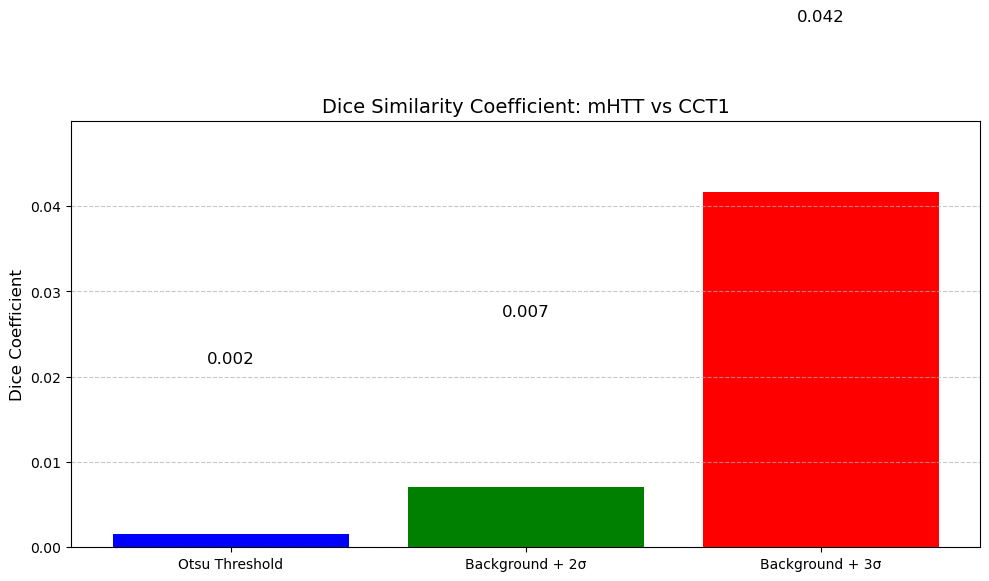

Dice Similarity Coefficient Results:
Otsu Threshold: 0.0016
Background + 2σ: 0.0071
Background + 3σ: 0.0417

Optimal CCT1 threshold: 53283.47
Maximum DSC achieved: 0.3410


In [10]:
def dice_coefficient(mask1, mask2):
    """
    Calculate Dice Similarity Coefficient between two binary masks
    DSC = 2*|intersection| / (|mask1| + |mask2|)
    """
    intersection = np.logical_and(mask1, mask2)
    if mask1.sum() + mask2.sum() == 0:
        return 0  # Avoid division by zero
    dice = (2.0 * intersection.sum()) / (mask1.sum() + mask2.sum())
    return dice

# Create binary masks for mHTT aggregates
mhtt_binary = labeled_mask > 0

# Create CCT1 binary masks using different thresholding methods
cct1_otsu_binary = CCT1 > cct1_thresh_otsu
cct1_bg2std_binary = CCT1 > cct1_thresh_bg_plus_2std
cct1_bg3std_binary = CCT1 > cct1_thresh_bg_plus_3std

# Calculate Dice coefficients for each method
dice_scores = {
    'Otsu Threshold': dice_coefficient(mhtt_binary, cct1_otsu_binary),
    'Background + 2σ': dice_coefficient(mhtt_binary, cct1_bg2std_binary),
    'Background + 3σ': dice_coefficient(mhtt_binary, cct1_bg3std_binary)
}

# Bar chart to visualize DSC values
plt.figure(figsize=(10, 6))
plt.bar(dice_scores.keys(), dice_scores.values(), color=['blue', 'green', 'red'])
plt.title('Dice Similarity Coefficient: mHTT vs CCT1', fontsize=14)
plt.ylabel('Dice Coefficient', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.ylim(0, max(list(dice_scores.values())) * 1.2)  # Set y limit with some padding

# Add text labels on top of each bar
for i, (key, value) in enumerate(dice_scores.items()):
    plt.text(i, value + 0.02, f"{value:.3f}", ha='center', fontsize=12)

plt.tight_layout()
plt.show()

# Calculate optimal threshold using a range of values
threshold_range = np.linspace(background_mean, background_mean + 5 * background_std, 20)
dsc_values = []

for threshold in threshold_range:
    cct1_mask = CCT1 > threshold
    dsc = dice_coefficient(mhtt_binary, cct1_mask)
    dsc_values.append(dsc)

# Find best threshold
best_threshold_idx = np.argmax(dsc_values)
best_threshold = threshold_range[best_threshold_idx]
best_dsc = dsc_values[best_threshold_idx]
best_cct1_mask = CCT1 > best_threshold

print(f"Dice Similarity Coefficient Results:")
for method, score in dice_scores.items():
    print(f"{method}: {score:.4f}")
    
print(f"\nOptimal CCT1 threshold: {best_threshold:.2f}")
print(f"Maximum DSC achieved: {best_dsc:.4f}")

In [13]:
import os
import json
import shutil
import numpy as np
from pathlib import Path
import SimpleITK as sitk
import nibabel as nib
from tifffile import imread, imwrite
from skimage import morphology, filters, measure
from aicsimageio import AICSImage
from sklearn.model_selection import train_test_split
from typing import List, Dict, Tuple, Union, Optional
import subprocess
import subprocess
from tempfile import TemporaryDirectory
import pandas as pd

class NNUNetIntegration:
    """
    Integrates nnU-Net into a biomedical image analysis pipeline for segmenting
    mHTT aggregates and CCT1 chaperone regions from fluorescence microscopy images.
    """
    
    def __init__(
        self, 
        base_dir: str = "nnUNet_data",
        task_name: str = "Task501_mHTT_CCT1",
        trainer_class: str = "nnUNetTrainer",
        fold: int = 0
    ):
        """
        Initialize the nnU-Net integration module.
        
        Args:
            base_dir: Base directory for nnU-Net data
            task_name: Task name (follows nnU-Net convention TaskXXX_NAME)
            trainer_class: nnU-Net trainer class to use
            fold: Fold number for training/validation split
        """
        self.base_dir = Path(base_dir)
        self.task_name = task_name
        self.task_id = int(task_name.split("_")[0][4:])
        self.trainer_class = trainer_class
        self.fold = fold
        
        # Create necessary directories
        self.dataset_dir = self.base_dir / "nnUNet_raw" / self.task_name
        self.preprocessed_dir = self.base_dir / "nnUNet_preprocessed" / self.task_name
        self.results_dir = self.base_dir / "nnUNet_results" / self.task_name
        
        # Create directory structure for nnUNet
        self._create_directory_structure()
        
        # Define paths for training and testing data
        self.imagesTr_dir = self.dataset_dir / "imagesTr"
        self.labelsTr_dir = self.dataset_dir / "labelsTr"
        self.imagesTs_dir = self.dataset_dir / "imagesTs"
        
        # Set environment variables for nnUNet
        os.environ["nnUNet_raw"] = str(self.base_dir / "nnUNet_raw")
        os.environ["nnUNet_preprocessed"] = str(self.base_dir / "nnUNet_preprocessed")
        os.environ["nnUNet_results"] = str(self.base_dir / "nnUNet_results")
    
    def _create_directory_structure(self) -> None:
        """Create the directory structure required by nnUNet."""
        for path in [
            self.base_dir,
            self.base_dir / "nnUNet_raw" / self.task_name / "imagesTr",
            self.base_dir / "nnUNet_raw" / self.task_name / "labelsTr",
            self.base_dir / "nnUNet_raw" / self.task_name / "imagesTs",
            self.base_dir / "nnUNet_preprocessed",
            self.base_dir / "nnUNet_results"
        ]:
            path.mkdir(parents=True, exist_ok=True)
    
    def prepare_training_data(
        self,
        image_files: List[str],
        mask_files: Optional[List[str]] = None,
        split_ratio: float = 0.2
    ) -> None:
        """
        Prepare training data by converting microscopy images to nnUNet format.
        
        Args:
            image_files: List of file paths to microscopy images (.tif, .lif)
            mask_files: List of file paths to existing segmentation masks, or None to generate from images
            split_ratio: Ratio of data to use for validation
        """
        # Split into training and testing sets
        train_files, test_files = train_test_split(
            list(zip(image_files, mask_files if mask_files else [None] * len(image_files))),
            test_size=split_ratio,
            random_state=42
        )
        
        # Process training files
        for i, (img_path, mask_path) in enumerate(train_files):
            case_id = f"{i:03d}"
            self._process_case(img_path, mask_path, case_id, is_training=True)
        
        # Process testing files
        for i, (img_path, mask_path) in enumerate(test_files):
            case_id = f"{i:03d}"
            self._process_case(img_path, mask_path, case_id, is_training=False)
        
        # Create dataset.json file
        self._create_dataset_json(len(train_files), len(test_files))
    
    def _process_case(
        self,
        img_path: str,
        mask_path: Optional[str],
        case_id: str,
        is_training: bool = True
    ) -> None:
        """
        Process a single case (image + mask) and save in nnUNet format.
        
        Args:
            img_path: Path to the microscopy image
            mask_path: Path to the segmentation mask, or None to generate from image
            case_id: Unique identifier for the case
            is_training: Whether this is a training case (True) or test case (False)
        """
        # Load image
        if img_path.lower().endswith(".lif"):
            img = AICSImage(img_path)
            # Extract mHTT and CCT1 channels
            mHTT_data = img.get_image_data("ZYX", C=0)  # Adjust channel indices if needed
            CCT1_data = img.get_image_data("ZYX", C=1)   # Adjust channel indices if needed
        else:  # Assume .tif/.tiff
            # For multi-channel TIFF - adjust according to actual file structure
            img_data = imread(img_path)
            if img_data.ndim == 4:  # (C, Z, Y, X)
                mHTT_data = img_data[0]
                CCT1_data = img_data[1]
            elif img_data.ndim == 3:  # (Z, Y, X) - assumed to be single channel
                mHTT_data = img_data
                # If only one channel available, create a dummy second channel
                CCT1_data = np.zeros_like(mHTT_data)
                print(f"Warning: Only one channel found in {img_path}. Creating dummy CCT1 channel.")
        
        # Normalize each channel
        mHTT_norm = self._normalize_channel(mHTT_data)
        CCT1_norm = self._normalize_channel(CCT1_data)
        
        # Combine channels into multi-channel image (C, Z, Y, X)
        input_image = np.stack([mHTT_norm, CCT1_norm], axis=0)
        
        # Process or load masks
        if mask_path is not None and os.path.exists(mask_path):
            # Load existing masks
            mask_data = imread(mask_path)
        else:
            # Generate masks using statistical segmentation
            mask_data = self._generate_masks(mHTT_data, CCT1_data)
        
        # Save as NIfTI files (nnUNet format)
        target_dir = self.imagesTr_dir if is_training else self.imagesTs_dir
        
        # Save input image (channels as 4th dimension in NIfTI)
        input_nifti_path = target_dir / f"{self.task_name}_{case_id}_0000.nii.gz"
        self._save_nifti(input_image, input_nifti_path)
        
        # Save segmentation mask (only for training data)
        if is_training:
            mask_nifti_path = self.labelsTr_dir / f"{self.task_name}_{case_id}.nii.gz"
            self._save_nifti(mask_data, mask_nifti_path)
    
    def _normalize_channel(self, data: np.ndarray) -> np.ndarray:
        """
        Normalize a channel to [0, 1] range.
        
        Args:
            data: Input image data
            
        Returns:
            Normalized image data
        """
        data = data.astype(np.float32)
        if data.max() > data.min():
            return (data - data.min()) / (data.max() - data.min())
        return data
    
    def _generate_masks(self, mHTT_data: np.ndarray, CCT1_data: np.ndarray) -> np.ndarray:
        """
        Generate segmentation masks using statistical methods (Otsu thresholding).
        
        Args:
            mHTT_data: mHTT channel data
            CCT1_data: CCT1 channel data
            
        Returns:
            Segmentation mask with classes:
            0: background
            1: mHTT aggregate
            2: CCT1 region
            3: colocalization (both mHTT and CCT1)
        """
        # Create maximum intensity projections
        mHTT_proj = np.max(mHTT_data, axis=0)
        CCT1_proj = np.max(CCT1_data, axis=0)
        
        # Apply Gaussian blur for noise reduction
        mHTT_blur = filters.gaussian(mHTT_proj, sigma=1)
        CCT1_blur = filters.gaussian(CCT1_proj, sigma=1)
        
        # Apply Otsu thresholding
        mHTT_thresh = filters.threshold_otsu(mHTT_blur)
        CCT1_thresh = filters.threshold_otsu(CCT1_blur)
        
        # Create binary masks
        mHTT_mask = mHTT_blur > mHTT_thresh
        CCT1_mask = CCT1_blur > CCT1_thresh
        
        # Clean up small objects
        mHTT_mask = morphology.remove_small_objects(mHTT_mask, min_size=20)
        CCT1_mask = morphology.remove_small_objects(CCT1_mask, min_size=20)
        
        # Create 3D masks by replicating 2D projections along Z axis
        mHTT_mask_3d = np.zeros_like(mHTT_data, dtype=np.uint8)
        CCT1_mask_3d = np.zeros_like(CCT1_data, dtype=np.uint8)
        
        for z in range(mHTT_data.shape[0]):
            # Apply thresholding for each z-slice based on projected values
            mHTT_slice = mHTT_data[z] > mHTT_thresh
            CCT1_slice = CCT1_data[z] > CCT1_thresh
            
            # Clean up small objects
            mHTT_mask_3d[z] = morphology.remove_small_objects(mHTT_slice, min_size=10)
            CCT1_mask_3d[z] = morphology.remove_small_objects(CCT1_slice, min_size=10)
        
        # Create final segmentation mask with class labels
        segmentation = np.zeros_like(mHTT_mask_3d, dtype=np.uint8)
        segmentation[mHTT_mask_3d] = 1  # mHTT regions
        segmentation[CCT1_mask_3d] = 2  # CCT1 regions
        # Overlapping regions (colocalization)
        segmentation[np.logical_and(mHTT_mask_3d, CCT1_mask_3d)] = 3
        
        return segmentation
    
    def _save_nifti(self, data: np.ndarray, output_path: Path) -> None:
        """
        Save numpy array as NIfTI file.
        
        Args:
            data: Input data (C, Z, Y, X) or (Z, Y, X)
            output_path: Path to save the NIfTI file
        """
        # Transpose data to match NIfTI format (Z, Y, X, C) for multi-channel data
        if data.ndim == 4:  # (C, Z, Y, X) -> (Z, Y, X, C)
            data = np.transpose(data, (1, 2, 3, 0))
        
        # Create NIfTI image
        nifti_img = nib.Nifti1Image(data, affine=np.eye(4))
        nib.save(nifti_img, output_path)
    
    def _create_dataset_json(self, num_training: int, num_testing: int) -> None:
        """
        Create dataset.json file required by nnUNet.
        
        Args:
            num_training: Number of training cases
            num_testing: Number of testing cases
        """
        dataset_info = {
            "name": self.task_name.split("_", 1)[1],
            "description": f"Automatic segmentation of mHTT aggregates and CCT1 chaperones",
            "reference": "Your lab/institution",
            "licence": "N/A",
            "release": "0.0",
            "tensorImageSize": "4D",
            "modality": {
                "0": "mHTT",
                "1": "CCT1"
            },
            "labels": {
                "0": "background",
                "1": "mHTT_aggregate",
                "2": "CCT1_region",
                "3": "colocalization"
            },
            "numTraining": num_training,
            "numTest": num_testing,
            "training": [{"image": f"./imagesTr/{self.task_name}_{i:03d}_0000.nii.gz", 
                          "label": f"./labelsTr/{self.task_name}_{i:03d}.nii.gz"} 
                         for i in range(num_training)],
            "test": [f"./imagesTs/{self.task_name}_{i:03d}_0000.nii.gz" 
                     for i in range(num_testing)]
        }
        
        # Save dataset.json
        with open(self.dataset_dir / "dataset.json", 'w') as f:
            json.dump(dataset_info, f, indent=4)
    
    def train(self) -> None:
        """Run nnUNet training using the prepared data."""
        
        # Set GPU environment variable if CUDA is available
        if os.environ.get("CUDA_VISIBLE_DEVICES") is None:
            os.environ["CUDA_VISIBLE_DEVICES"] = "0"
            
        # Run preprocessing
        subprocess.run([
            "nnUNetv2_plan_and_preprocess",
            "-d", str(self.task_id),
            "-c", "3d_fullres"
        ])
        
        # Run training
        subprocess.run([
            "nnUNetv2_train",
            f"{self.task_id}", "3d_fullres", str(self.fold),
            "-tr", self.trainer_class
        ])
    
    def inference(self, input_file: str, output_dir: str) -> Dict[str, np.ndarray]:
        """
        Run inference on a new image file.
        
        Args:
            input_file: Path to the input microscopy image (.tif, .lif)
            output_dir: Directory to save output segmentation masks
        
        Returns:
            Dictionary of segmentation masks for each class
        """
        
        with TemporaryDirectory() as temp_dir:
            # Convert input file to nnUNet format
            case_id = Path(input_file).stem
            input_nifti_path = Path(temp_dir) / f"{case_id}_0000.nii.gz"
            
            # Load and process image
            if input_file.lower().endswith(".lif"):
                img = AICSImage(input_file)
                mHTT_data = img.get_image_data("ZYX", C=0)
                CCT1_data = img.get_image_data("ZYX", C=1)
            else:
                img_data = imread(input_file)
                if img_data.ndim == 4:  # (C, Z, Y, X)
                    mHTT_data = img_data[0]
                    CCT1_data = img_data[1]
                else:
                    mHTT_data = img_data
                    CCT1_data = np.zeros_like(mHTT_data)
            
            # Normalize channels
            mHTT_norm = self._normalize_channel(mHTT_data)
            CCT1_norm = self._normalize_channel(CCT1_data)
            
            # Combine channels
            input_image = np.stack([mHTT_norm, CCT1_norm], axis=0)
            
            # Save as NIfTI
            self._save_nifti(input_image, input_nifti_path)
            
            # Run inference
            output_path = Path(output_dir) / f"{case_id}"
            output_path.mkdir(parents=True, exist_ok=True)
            
            subprocess.run([
                "nnUNetv2_predict",
                "-i", temp_dir,
                "-o", str(output_path),
                "-d", str(self.task_id),
                "-c", "3d_fullres",
                "-f", str(self.fold),
                "--save_probabilities"
            ])
            
            # Load segmentation result
            seg_file = output_path / f"{case_id}.nii.gz"
            seg_nifti = nib.load(seg_file)
            segmentation = seg_nifti.get_fdata().astype(np.uint8)
            
            # Extract individual segmentation masks
            masks = {
                "mHTT": (segmentation == 1) | (segmentation == 3),
                "CCT1": (segmentation == 2) | (segmentation == 3),
                "colocalization": segmentation == 3,
                "background": segmentation == 0
            }
            
            # Save individual masks as TIFF files
            for name, mask in masks.items():
                imwrite(output_path / f"{name}_mask.tif", mask.astype(np.uint8))
            
            return masks
    
    def analyze_colocalization(self, masks: Dict[str, np.ndarray], cellpose_masks: np.ndarray) -> pd.DataFrame:
        """
        Analyze colocalization between mHTT and CCT1 with respect to cell masks.
        
        Args:
            masks: Dictionary of segmentation masks from nnUNet inference
            cellpose_masks: Cell instance segmentation masks from Cellpose
        
        Returns:
            DataFrame with colocalization metrics per cell
        """
        
        # Get masks
        mhtt_mask = masks["mHTT"]
        cct1_mask = masks["CCT1"]
        coloc_mask = masks["colocalization"]
        
        # Create empty dataframe for results
        results = []
        
        # Analyze each cell from Cellpose segmentation
        for cell_id in np.unique(cellpose_masks):
            if cell_id == 0:  # Skip background
                continue
                
            # Create mask for this cell
            cell_mask = cellpose_masks == cell_id
            
            # Calculate metrics
            cell_area = np.sum(cell_mask)
            mhtt_in_cell = np.sum(mhtt_mask & cell_mask)
            cct1_in_cell = np.sum(cct1_mask & cell_mask)
            coloc_in_cell = np.sum(coloc_mask & cell_mask)
            
            # Calculate percentages
            mhtt_percent = 100 * mhtt_in_cell / cell_area if cell_area > 0 else 0
            cct1_percent = 100 * cct1_in_cell / cell_area if cell_area > 0 else 0
            coloc_percent = 100 * coloc_in_cell / cell_area if cell_area > 0 else 0
            
            # Calculate Dice coefficient for colocalization
            dice = 2 * coloc_in_cell / (mhtt_in_cell + cct1_in_cell) if (mhtt_in_cell + cct1_in_cell) > 0 else 0
            
            # Store results
            results.append({
                "cell_id": cell_id,
                "cell_area": cell_area,
                "mhtt_area": mhtt_in_cell,
                "cct1_area": cct1_in_cell,
                "coloc_area": coloc_in_cell,
                "mhtt_percent": mhtt_percent,
                "cct1_percent": cct1_percent,
                "coloc_percent": coloc_percent,
                "dice_coefficient": dice
            })
        
        return pd.DataFrame(results)


# def main():
#     """
#     Main function demonstrating the use of the nnUNet integration module.
#     """
#     # Use your actual data path
#     image_dir = Path("/Users/noahwijnheijmer/Library/CloudStorage/OneDrive-HvA/afstuderen/Images/E35")
#     output_dir = "results"
#     base_dir = "nnunet_huntington"
#     mask_files = None  # Optional, if using auto-generated masks

#     # Try both .lif and .tif if unsure which format is used
#     image_files = [str(f) for f in image_dir.glob("*.lif")] + [str(f) for f in image_dir.glob("*.tif")]

#     # Confirm file discovery
#     if not image_files:
#         raise ValueError(f"No .lif or .tif files found in {image_dir}")
#     print(f"Found {len(image_files)} image(s) for training.")

#     # Initialize nnUNet integration
#     nnunet = NNUNetIntegration(base_dir=base_dir)

#     # Prepare data
#     nnunet.prepare_training_data(image_files, mask_files)

#     # (Optional) Train the model
#     # nnunet.train()

#     # Example inference on one of the images
#     test_image = image_files[0]
#     masks = nnunet.inference(test_image, output_dir)

#     # If Cellpose masks are available, run colocalization
#     cellpose_mask_file = "cellpose_masks.tif"
#     if os.path.exists(cellpose_mask_file):
#         from tifffile import imread
#         cellpose_masks = imread(cellpose_mask_file)
#         results_df = nnunet.analyze_colocalization(masks, cellpose_masks)
#         results_df.to_csv(f"{output_dir}/colocalization_analysis.csv", index=False)
#         print(f"Colocalization analysis saved to {output_dir}/colocalization_analysis.csv")


if __name__ == "__main__":
    main()

Testing with: /Users/noahwijnheijmer/Library/CloudStorage/OneDrive-HvA/afstuderen/Images/E35/20242911_CKR_Exp35_STHdhQ97HA_72h_+bafCCT1_635P_HA_580_A11_460L_2.lif
mHTT shape: (3, 1024, 1024), CCT1 shape: (3, 1024, 1024)
✅ Saved test NIfTI with shape: (3, 1024, 1024, 2)
✅ Generated test mask and saved.


In [12]:
def main():
    """
    Lightweight test of nnUNetIntegration using only the first image and a few z-slices.
    """
    from pathlib import Path

    # 1. Use only the first available LIF or TIFF file
    image_dir = Path("/Users/noahwijnheijmer/Library/CloudStorage/OneDrive-HvA/afstuderen/Images/E35")
    output_dir = "results_test"
    base_dir = "nnunet_huntington_test"
    mask_files = None

    # Collect image files
    image_files = [str(f) for f in image_dir.glob("*.lif")] + [str(f) for f in image_dir.glob("*.tif")]
    if not image_files:
        raise ValueError(f"No .lif or .tif files found in {image_dir}")

    test_image = image_files[0]
    print(f"Testing with: {test_image}")

    # 2. Load only 3 z-slices (instead of full volume)
    from aicsimageio import AICSImage

    if test_image.lower().endswith(".lif"):
        img = AICSImage(test_image)
        mHTT_data = img.get_image_data("ZYX", C=0)[:3]  # use first 3 Z slices
        CCT1_data = img.get_image_data("ZYX", C=1)[:3]
    else:
        from tifffile import imread
        img_data = imread(test_image)
        if img_data.ndim == 4:  # (C, Z, Y, X)
            mHTT_data = img_data[0][:3]
            CCT1_data = img_data[1][:3]
        else:
            mHTT_data = img_data[:3]
            CCT1_data = np.zeros_like(mHTT_data)

    print(f"mHTT shape: {mHTT_data.shape}, CCT1 shape: {CCT1_data.shape}")

    # 3. Save NIfTI just to confirm I/O is working
    from nibabel import Nifti1Image, save
    from pathlib import Path
    import numpy as np

    input_image = np.stack([
        (mHTT_data - mHTT_data.min()) / (mHTT_data.max() - mHTT_data.min() + 1e-8),
        (CCT1_data - CCT1_data.min()) / (CCT1_data.max() - CCT1_data.min() + 1e-8)
    ], axis=0)

    # Transpose to (Z, Y, X, C)
    nifti_ready = np.transpose(input_image, (1, 2, 3, 0))
    out_path = Path(output_dir)
    out_path.mkdir(parents=True, exist_ok=True)
    save(Nifti1Image(nifti_ready, affine=np.eye(4)), out_path / "test_input.nii.gz")

    print("✅ Saved test NIfTI with shape:", nifti_ready.shape)

    # Optional: run mask generation
    nnunet = NNUNetIntegration(base_dir=base_dir)
    test_mask = nnunet._generate_masks(mHTT_data, CCT1_data)
    save(Nifti1Image(test_mask, affine=np.eye(4)), out_path / "test_mask.nii.gz")

    print("✅ Generated test mask and saved.")

    # Skip training/inference for now — we just verified I/O works

In [14]:
main()

Testing with: /Users/noahwijnheijmer/Library/CloudStorage/OneDrive-HvA/afstuderen/Images/E35/20242911_CKR_Exp35_STHdhQ97HA_72h_+bafCCT1_635P_HA_580_A11_460L_2.lif
mHTT shape: (3, 1024, 1024), CCT1 shape: (3, 1024, 1024)
✅ Saved test NIfTI with shape: (3, 1024, 1024, 2)
✅ Generated test mask and saved.


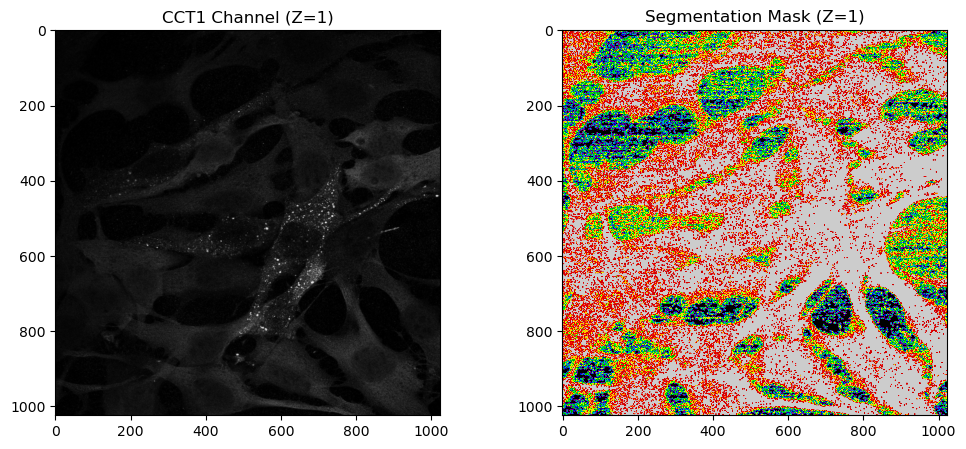

In [15]:
import nibabel as nib
import matplotlib.pyplot as plt

img = nib.load("results_test/test_input.nii.gz").get_fdata()
mask = nib.load("results_test/test_mask.nii.gz").get_fdata()

# Visualize one slice (Z = 1)
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.title("CCT1 Channel (Z=1)")
plt.imshow(img[1, :, :, 1], cmap="gray")

plt.subplot(1, 2, 2)
plt.title("Segmentation Mask (Z=1)")
plt.imshow(mask[1, :, :], cmap="nipy_spectral")

plt.show()